# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 1 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

global threshold_low1, threshold_high1, threshold_low2, threshold_high2
threshold_low1 = 0 #300 works
threshold_high1 = 60
threshold_low2 = 500 #300 works
threshold_high2 = 2000

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-5+(((x+5)*(5--5))/(51+5)))
def ynew(y): 
    return (-5+(((y+2)*(5--5))/(53+2)))

def hblau(x):
       
#     return ((1.5-(x[0])+(x[0]*x[1]))**2)+ ((2.25-(x[0])+(x[0]*(x[1]**2)))**2)+ ((2.625-(x[0])+(x[0]*(x[1]**3)))**2)
    return ((((x[0]**2)+(x[1])-11)**2)+(((x[0])+((x[1])**2)-7)**2))

def hblauColor(x, threshold_low1, threshold_high1, threshold_low2, threshold_high2):
    
    if (threshold_low1<hblau((xnew(x[0]),xnew(x[1])))<threshold_high1)|(threshold_low2<hblau((xnew(x[0]),xnew(x[1])))<threshold_high2):
        return 1
    else:
        return 0
      

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zhblau
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .2  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zhblau = []
    hblaucoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(77000):
        Zhblau.append(hblauColor(hblaucoords[i],threshold_low1,threshold_high1,threshold_low2,threshold_high2))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zhblau)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(77000):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


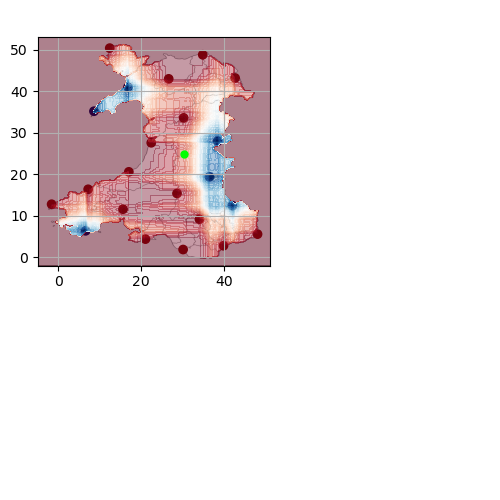

iteration  1
Accuracy is 0.42495234581565516
iteration  2
Accuracy is 0.7998524257517063
iteration  3
Accuracy is 0.7983766832687696
iteration  4
Accuracy is 0.7755641640533727
iteration  5
Accuracy is 0.7679087499231384
iteration  6
Accuracy is 0.7724897005472545
iteration  7
Accuracy is 0.774088421570436
iteration  8
Accuracy is 0.7927504150525734
iteration  9
Accuracy is 0.8411117260038123
iteration  10
Accuracy is 0.8633400971530468
iteration  11
Accuracy is 0.8555002152124455
iteration  12
Accuracy is 0.8777593309967411
iteration  13
Accuracy is 0.8708417881079752
iteration  14
Accuracy is 0.8614954190493759
iteration  15
Accuracy is 0.8444936358605424
iteration  16
Accuracy is 0.8525794748816331
iteration  17
Accuracy is 0.8367767324601857
iteration  18
Accuracy is 0.8333640779683945
iteration  19
Accuracy is 0.8460001229785402
iteration  20
Accuracy is 0.8261390887290168
iteration  21
Accuracy is 0.8194982475558015
experiment:  1


<IPython.core.display.Javascript object>


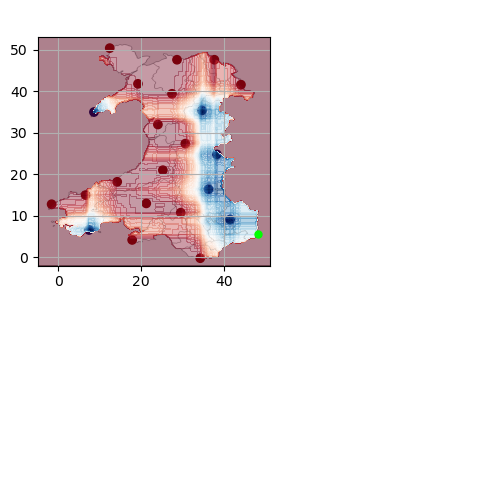

iteration  1
Accuracy is 0.6782573940847322
iteration  2
Accuracy is 0.7116768123962368
iteration  3
Accuracy is 0.6924921601180594
iteration  4
Accuracy is 0.708325647174568
iteration  5
Accuracy is 0.6854823833241099
iteration  6
Accuracy is 0.6951054540982599
iteration  7
Accuracy is 0.6926458832933653
iteration  8
Accuracy is 0.7683699194490562
iteration  9
Accuracy is 0.774426612556109
iteration  10
Accuracy is 0.7872163807415606
iteration  11
Accuracy is 0.8190063333948226
iteration  12
Accuracy is 0.8726249769415237
iteration  13
Accuracy is 0.8657074340527577
iteration  14
Accuracy is 0.864908073541167
iteration  15
Accuracy is 0.8800959232613909
iteration  16
Accuracy is 0.8681362602225912
iteration  17
Accuracy is 0.8663530713890426
iteration  18
Accuracy is 0.863709032773781
iteration  19
Accuracy is 0.8533788353932239
iteration  20
Accuracy is 0.8406813011129558
iteration  21
Accuracy is 0.8497817130910656
experiment:  2


<IPython.core.display.Javascript object>


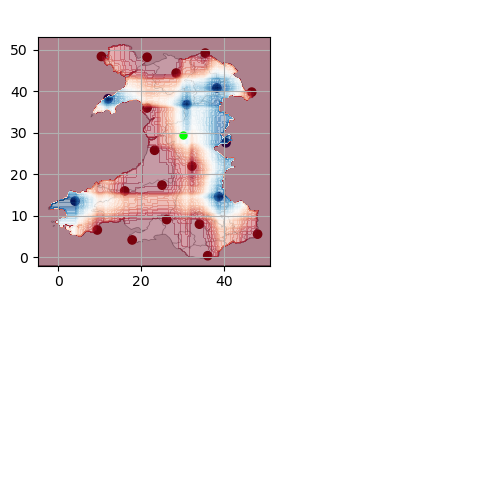

iteration  1
Accuracy is 0.4017094017094017
iteration  2
Accuracy is 0.6497263727479555
iteration  3
Accuracy is 0.5754473344401402
iteration  4
Accuracy is 0.6051466519092419
iteration  5
Accuracy is 0.557830658550083
iteration  6
Accuracy is 0.7246203037569944
iteration  7
Accuracy is 0.7571173830166636
iteration  8
Accuracy is 0.7674475803972207
iteration  9
Accuracy is 0.7299391256225789
iteration  10
Accuracy is 0.7494927135214905
iteration  11
Accuracy is 0.6909241837299391
iteration  12
Accuracy is 0.7919510545409826
iteration  13
Accuracy is 0.8104285802127529
iteration  14
Accuracy is 0.8127344278423415
iteration  15
Accuracy is 0.8040336961200271
iteration  16
Accuracy is 0.8222037754411855
iteration  17
Accuracy is 0.8411732152739347
iteration  18
Accuracy is 0.8282297239131772
iteration  19
Accuracy is 0.843602041443768
iteration  20
Accuracy is 0.8469224620303757
iteration  21
Accuracy is 0.8651232859865954
experiment:  3


<IPython.core.display.Javascript object>


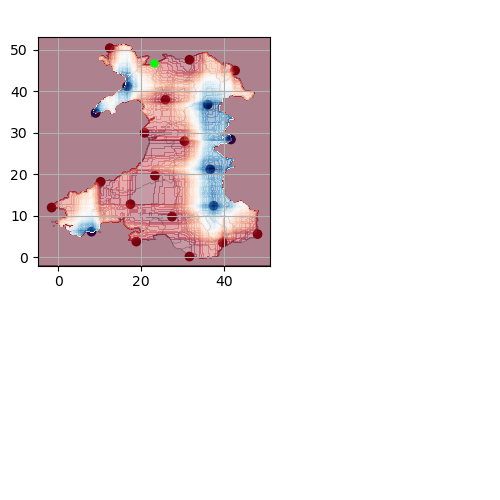

iteration  1
Accuracy is 0.5855930640103302
iteration  2
Accuracy is 0.7006087437742115
iteration  3
Accuracy is 0.6558445551251306
iteration  4
Accuracy is 0.6598106130480231
iteration  5
Accuracy is 0.6894484412470024
iteration  6
Accuracy is 0.7238516878804648
iteration  7
Accuracy is 0.7623439709770645
iteration  8
Accuracy is 0.7743036340158642
iteration  9
Accuracy is 0.798622640349259
iteration  10
Accuracy is 0.7980384922830966
iteration  11
Accuracy is 0.8132570866383816
iteration  12
Accuracy is 0.8022505072864785
iteration  13
Accuracy is 0.8057861403185144
iteration  14
Accuracy is 0.8028039107175797
iteration  15
Accuracy is 0.7899219086269446
iteration  16
Accuracy is 0.8562073418188526
iteration  17
Accuracy is 0.8566992559798315
iteration  18
Accuracy is 0.874715612125684
iteration  19
Accuracy is 0.8604193568222345
iteration  20
Accuracy is 0.8546393654307324
iteration  21
Accuracy is 0.8463690585992745
experiment:  4


<IPython.core.display.Javascript object>


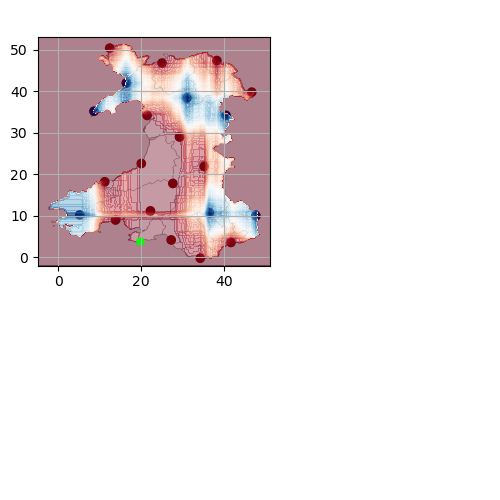

iteration  1
Accuracy is 0.6049314394638136
iteration  2
Accuracy is 0.5934329459509315
iteration  3
Accuracy is 0.6061304802311996
iteration  4
Accuracy is 0.6690340035663777
iteration  5
Accuracy is 0.6781036709094264
iteration  6
Accuracy is 0.6920002459570805
iteration  7
Accuracy is 0.7310459324847814
iteration  8
Accuracy is 0.7692615138658304
iteration  9
Accuracy is 0.7755026747832503
iteration  10
Accuracy is 0.7724282112771321
iteration  11
Accuracy is 0.7679087499231384
iteration  12
Accuracy is 0.7733812949640287
iteration  13
Accuracy is 0.812826661747525
iteration  14
Accuracy is 0.8428026809321774
iteration  15
Accuracy is 0.8189755887597614
iteration  16
Accuracy is 0.8476295886367828
iteration  17
Accuracy is 0.8669372194552051
iteration  18
Accuracy is 0.8416343847998524
iteration  19
Accuracy is 0.8405890672077723
iteration  20
Accuracy is 0.8431716165529115
iteration  21
Accuracy is 0.845446719547439
experiment:  5


<IPython.core.display.Javascript object>


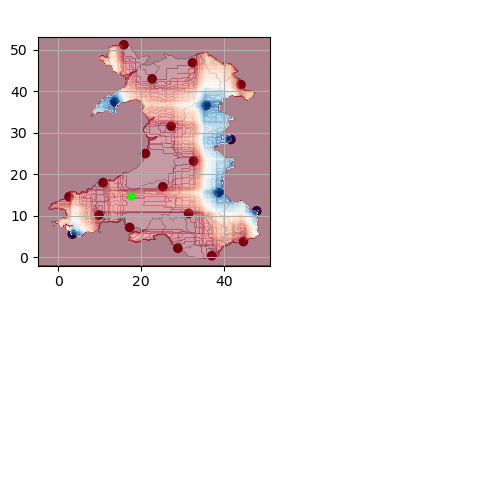

iteration  1
Accuracy is 0.39995695751091437
iteration  2
Accuracy is 0.5236118797269876
iteration  3
Accuracy is 0.38403123654922217
iteration  4
Accuracy is 0.6319867183176535
iteration  5
Accuracy is 0.688526102195167
iteration  6
Accuracy is 0.6875730185082704
iteration  7
Accuracy is 0.7185021213798192
iteration  8
Accuracy is 0.7825124515771997
iteration  9
Accuracy is 0.7740576769353747
iteration  10
Accuracy is 0.8061243313041874
iteration  11
Accuracy is 0.8223882432515526
iteration  12
Accuracy is 0.8274611080366476
iteration  13
Accuracy is 0.8331488655229663
iteration  14
Accuracy is 0.8705958310274857
iteration  15
Accuracy is 0.8629404168972514
iteration  16
Accuracy is 0.8574678718563611
iteration  17
Accuracy is 0.8473528869212322
iteration  18
Accuracy is 0.8615569083194983
iteration  19
Accuracy is 0.8491053311197196
iteration  20
Accuracy is 0.8602963782819898
iteration  21
Accuracy is 0.8584824448133801
experiment:  6


<IPython.core.display.Javascript object>


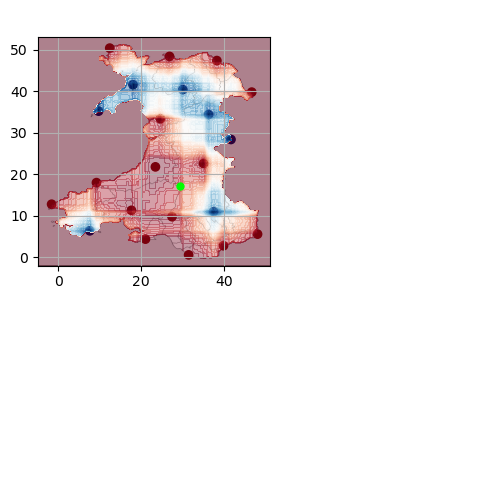

iteration  1
Accuracy is 0.6987640656705405
iteration  2
Accuracy is 0.6957818360696059
iteration  3
Accuracy is 0.6888335485457787
iteration  4
Accuracy is 0.7099243681977495
iteration  5
Accuracy is 0.7148435098075386
iteration  6
Accuracy is 0.7185943552850028
iteration  7
Accuracy is 0.7163192522904753
iteration  8
Accuracy is 0.7172415913423108
iteration  9
Accuracy is 0.7129065977986841
iteration  10
Accuracy is 0.7465719731906783
iteration  11
Accuracy is 0.8215581381049007
iteration  12
Accuracy is 0.8178687818975588
iteration  13
Accuracy is 0.782881387197934
iteration  14
Accuracy is 0.794379880710816
iteration  15
Accuracy is 0.8259238762835885
iteration  16
Accuracy is 0.7917050974604931
iteration  17
Accuracy is 0.7982537047285249
iteration  18
Accuracy is 0.7888765910348644
iteration  19
Accuracy is 0.7895529730062104
iteration  20
Accuracy is 0.8127651724774027
iteration  21
Accuracy is 0.8078460308676136
experiment:  7


<IPython.core.display.Javascript object>


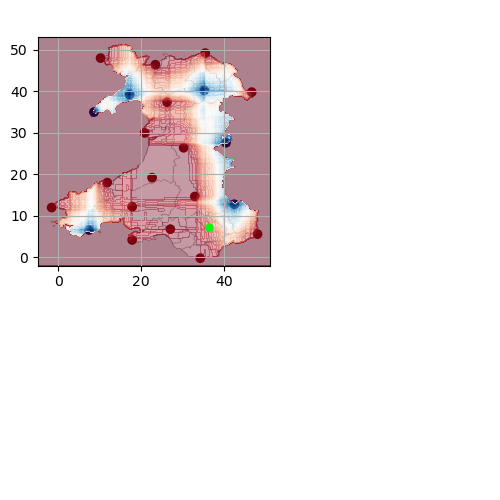

iteration  1
Accuracy is 0.8035725265941094
iteration  2
Accuracy is 0.6563672139211708
iteration  3
Accuracy is 0.7451577199778638
iteration  4
Accuracy is 0.754135153415729
iteration  5
Accuracy is 0.7045440570620427
iteration  6
Accuracy is 0.729785402447273
iteration  7
Accuracy is 0.7220377544118551
iteration  8
Accuracy is 0.7244973252167497
iteration  9
Accuracy is 0.7616368443706574
iteration  10
Accuracy is 0.7768246940908812
iteration  11
Accuracy is 0.7912746725696366
iteration  12
Accuracy is 0.7936727541044087
iteration  13
Accuracy is 0.8140257025149111
iteration  14
Accuracy is 0.8155321896329091
iteration  15
Accuracy is 0.7771936297116153
iteration  16
Accuracy is 0.7833425567238517
iteration  17
Accuracy is 0.8026194429072127
iteration  18
Accuracy is 0.7920432884461661
iteration  19
Accuracy is 0.8578982967472176
iteration  20
Accuracy is 0.8567914898850151
iteration  21
Accuracy is 0.8263543011744451
experiment:  8


<IPython.core.display.Javascript object>


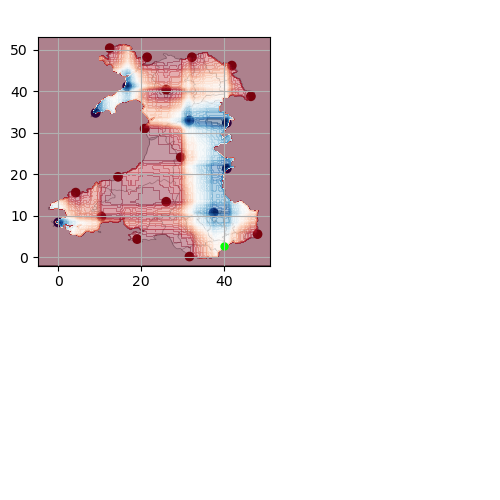

iteration  1
Accuracy is 0.7219762651417327
iteration  2
Accuracy is 0.5187542273873209
iteration  3
Accuracy is 0.589620611203345
iteration  4
Accuracy is 0.599428149787862
iteration  5
Accuracy is 0.6840988747463568
iteration  6
Accuracy is 0.7342741191662056
iteration  7
Accuracy is 0.7131832995142348
iteration  8
Accuracy is 0.7246510483920556
iteration  9
Accuracy is 0.8030806124331304
iteration  10
Accuracy is 0.832779929902232
iteration  11
Accuracy is 0.8086453913792043
iteration  12
Accuracy is 0.8544548976203652
iteration  13
Accuracy is 0.8554387259423231
iteration  14
Accuracy is 0.8368074770952468
iteration  15
Accuracy is 0.8235565393838775
iteration  16
Accuracy is 0.8184221853286602
iteration  17
Accuracy is 0.8426797023919326
iteration  18
Accuracy is 0.8491975650249032
iteration  19
Accuracy is 0.8493820328352703
iteration  20
Accuracy is 0.8606345692676628
iteration  21
Accuracy is 0.8290905736948903
experiment:  9


<IPython.core.display.Javascript object>


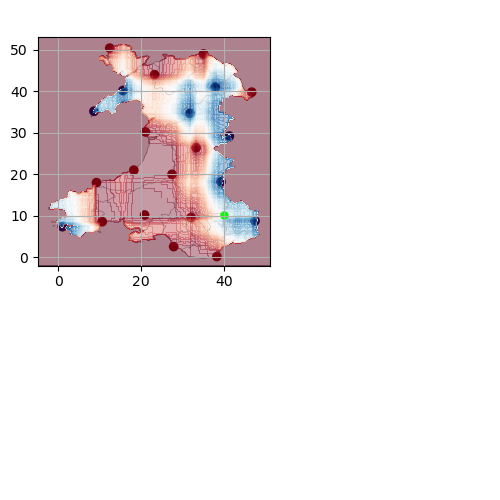

iteration  1
Accuracy is 0.6181516325401217
iteration  2
Accuracy is 0.6260837483859066
iteration  3
Accuracy is 0.49093033265695135
iteration  4
Accuracy is 0.649295947857099
iteration  5
Accuracy is 0.705958310274857
iteration  6
Accuracy is 0.733167312304003
iteration  7
Accuracy is 0.7660948164545287
iteration  8
Accuracy is 0.7356883723790199
iteration  9
Accuracy is 0.7678780052880773
iteration  10
Accuracy is 0.7768861833610035
iteration  11
Accuracy is 0.779837668326877
iteration  12
Accuracy is 0.7887843571296809
iteration  13
Accuracy is 0.8665375391994097
iteration  14
Accuracy is 0.8365307753796962
iteration  15
Accuracy is 0.8661378589436144
iteration  16
Accuracy is 0.8549775564164054
iteration  17
Accuracy is 0.8583594662731353
iteration  18
Accuracy is 0.8807108159626145
iteration  19
Accuracy is 0.8806493266924922
iteration  20
Accuracy is 0.8675521121564287
iteration  21
Accuracy is 0.8980507901371211
experiment:  10


<IPython.core.display.Javascript object>


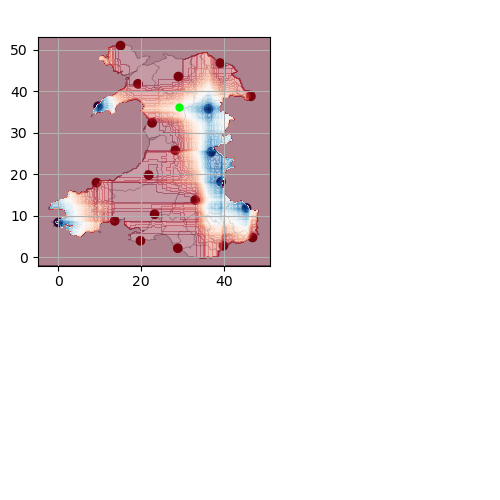

iteration  1
Accuracy is 0.6919387566869581
iteration  2
Accuracy is 0.4361741376129865
iteration  3
Accuracy is 0.5585377851564902
iteration  4
Accuracy is 0.6452376560290229
iteration  5
Accuracy is 0.7262805140502983
iteration  6
Accuracy is 0.7438357006702331
iteration  7
Accuracy is 0.7671401340466089
iteration  8
Accuracy is 0.7945336038861218
iteration  9
Accuracy is 0.8082457111234089
iteration  10
Accuracy is 0.8309659964336223
iteration  11
Accuracy is 0.8447395929410317
iteration  12
Accuracy is 0.8187603763143332
iteration  13
Accuracy is 0.799637213306278
iteration  14
Accuracy is 0.8442476787800529
iteration  15
Accuracy is 0.8266002582549346
iteration  16
Accuracy is 0.8333025886982721
iteration  17
Accuracy is 0.8290598290598291
iteration  18
Accuracy is 0.8445243804956035
iteration  19
Accuracy is 0.8643546701100658
iteration  20
Accuracy is 0.8742851872348275
iteration  21
Accuracy is 0.8654922216073295
experiment:  11


<IPython.core.display.Javascript object>


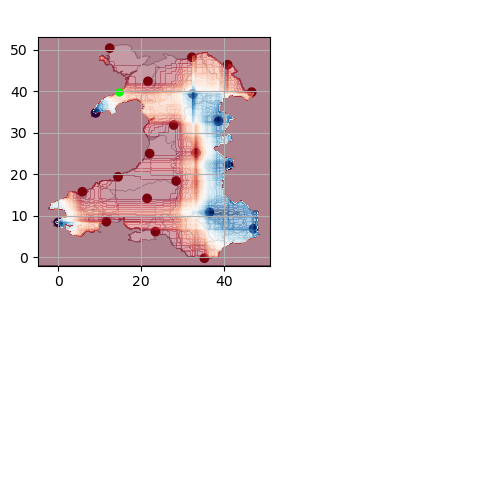

iteration  1
Accuracy is 0.6807169648896267
iteration  2
Accuracy is 0.5126975342802681
iteration  3
Accuracy is 0.5522351349689479
iteration  4
Accuracy is 0.6998093832626207
iteration  5
Accuracy is 0.6947365184775257
iteration  6
Accuracy is 0.6933530098997724
iteration  7
Accuracy is 0.6981491729693169
iteration  8
Accuracy is 0.757363340097153
iteration  9
Accuracy is 0.7720285310213367
iteration  10
Accuracy is 0.8081842218532866
iteration  11
Accuracy is 0.8152554879173585
iteration  12
Accuracy is 0.8123962368566685
iteration  13
Accuracy is 0.8098136875115293
iteration  14
Accuracy is 0.8063087991145546
iteration  15
Accuracy is 0.8409887474635676
iteration  16
Accuracy is 0.8359158826784726
iteration  17
Accuracy is 0.8379450285925106
iteration  18
Accuracy is 0.8849843202361188
iteration  19
Accuracy is 0.8640779683945151
iteration  20
Accuracy is 0.8633093525179856
iteration  21
Accuracy is 0.8698272151509562
experiment:  12


<IPython.core.display.Javascript object>


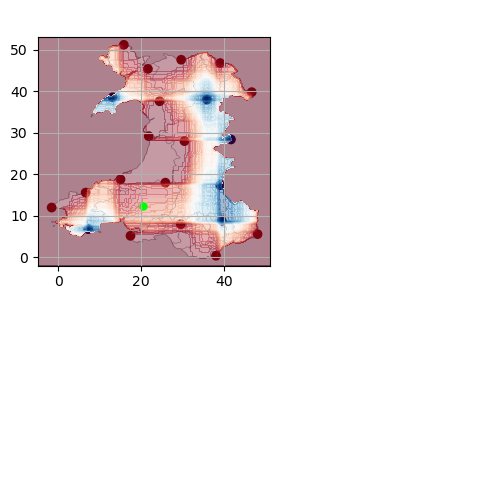

iteration  1
Accuracy is 0.5162639119473652
iteration  2
Accuracy is 0.6134784480108221
iteration  3
Accuracy is 0.6452376560290229
iteration  4
Accuracy is 0.6500645637336285
iteration  5
Accuracy is 0.7030683145791059
iteration  6
Accuracy is 0.7100473467379942
iteration  7
Accuracy is 0.7103855377236672
iteration  8
Accuracy is 0.7455574002336592
iteration  9
Accuracy is 0.7495234581565516
iteration  10
Accuracy is 0.7550574924675644
iteration  11
Accuracy is 0.7510299452745496
iteration  12
Accuracy is 0.7469101641763513
iteration  13
Accuracy is 0.7844801082211155
iteration  14
Accuracy is 0.8408350242882617
iteration  15
Accuracy is 0.8312119535141118
iteration  16
Accuracy is 0.8499354362663715
iteration  17
Accuracy is 0.8563610649941585
iteration  18
Accuracy is 0.846123101518785
iteration  19
Accuracy is 0.8498432023611879
iteration  20
Accuracy is 0.872163807415606
iteration  21
Accuracy is 0.8443091680501752
experiment:  13


<IPython.core.display.Javascript object>


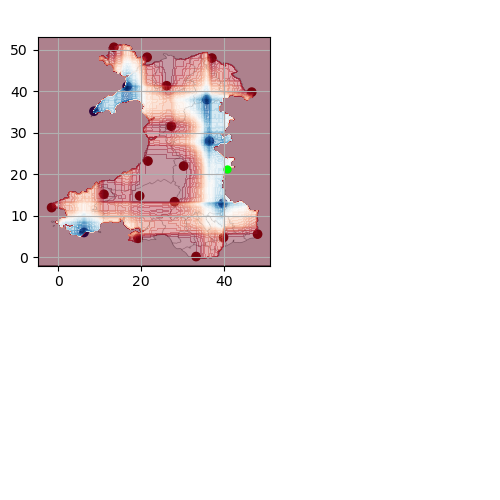

iteration  1
Accuracy is 0.6788415421508947
iteration  2
Accuracy is 0.6697411301727848
iteration  3
Accuracy is 0.7457418680440263
iteration  4
Accuracy is 0.7386706019799545
iteration  5
Accuracy is 0.7562872778700117
iteration  6
Accuracy is 0.7256656213490746
iteration  7
Accuracy is 0.7444198487363956
iteration  8
Accuracy is 0.7450347414376192
iteration  9
Accuracy is 0.8076615630572465
iteration  10
Accuracy is 0.8277685543872594
iteration  11
Accuracy is 0.8168849535756011
iteration  12
Accuracy is 0.8212506917542889
iteration  13
Accuracy is 0.81061304802312
iteration  14
Accuracy is 0.8409272581934453
iteration  15
Accuracy is 0.85457787616061
iteration  16
Accuracy is 0.8701039168665068
iteration  17
Accuracy is 0.8788353932238824
iteration  18
Accuracy is 0.8792965627498002
iteration  19
Accuracy is 0.8907643116276209
iteration  20
Accuracy is 0.8730861464674414
iteration  21
Accuracy is 0.8663223267539815
experiment:  14


<IPython.core.display.Javascript object>


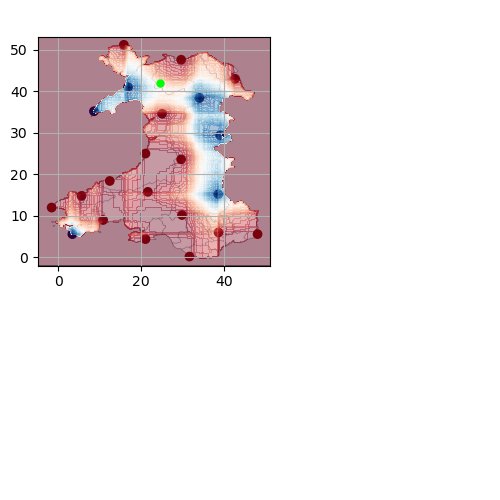

iteration  1
Accuracy is 0.5460247186865892
iteration  2
Accuracy is 0.7350427350427351
iteration  3
Accuracy is 0.7129373424337453
iteration  4
Accuracy is 0.7142593617413762
iteration  5
Accuracy is 0.7261882801451147
iteration  6
Accuracy is 0.750415052573326
iteration  7
Accuracy is 0.7782696919387567
iteration  8
Accuracy is 0.8137797454344217
iteration  9
Accuracy is 0.8297977003012974
iteration  10
Accuracy is 0.7887228678595585
iteration  11
Accuracy is 0.7856484043534403
iteration  12
Accuracy is 0.7992067884154215
iteration  13
Accuracy is 0.7935805201992252
iteration  14
Accuracy is 0.8119043226956896
iteration  15
Accuracy is 0.8048330566316177
iteration  16
Accuracy is 0.8491360757547808
iteration  17
Accuracy is 0.8508577753182069
iteration  18
Accuracy is 0.8388058783742237
iteration  19
Accuracy is 0.8270614277808522
iteration  20
Accuracy is 0.8358543934083502
iteration  21
Accuracy is 0.8425259792166268
experiment:  15


<IPython.core.display.Javascript object>


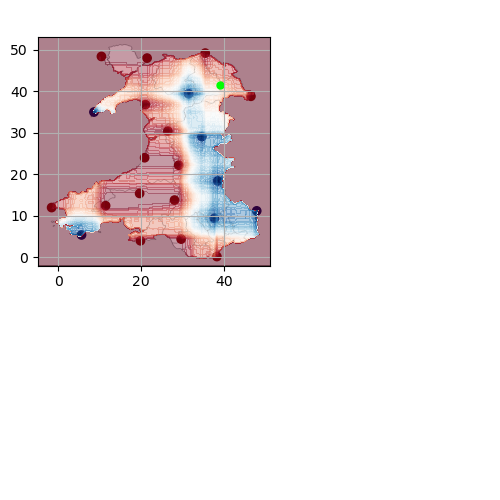

iteration  1
Accuracy is 0.5423661071143085
iteration  2
Accuracy is 0.5768615876529546
iteration  3
Accuracy is 0.5798438172538892
iteration  4
Accuracy is 0.601119104716227
iteration  5
Accuracy is 0.6997171493574371
iteration  6
Accuracy is 0.7112156428703191
iteration  7
Accuracy is 0.7039906536309414
iteration  8
Accuracy is 0.7654491791182438
iteration  9
Accuracy is 0.7260960462399312
iteration  10
Accuracy is 0.7181946750292074
iteration  11
Accuracy is 0.7364262436204883
iteration  12
Accuracy is 0.7403615569083195
iteration  13
Accuracy is 0.7878620180778454
iteration  14
Accuracy is 0.7933345631187357
iteration  15
Accuracy is 0.790659779868413
iteration  16
Accuracy is 0.8028039107175797
iteration  17
Accuracy is 0.8213736702945336
iteration  18
Accuracy is 0.8088298591895714
iteration  19
Accuracy is 0.8071696488962676
iteration  20
Accuracy is 0.8262313226342003
iteration  21
Accuracy is 0.8339174813994958
experiment:  16


<IPython.core.display.Javascript object>


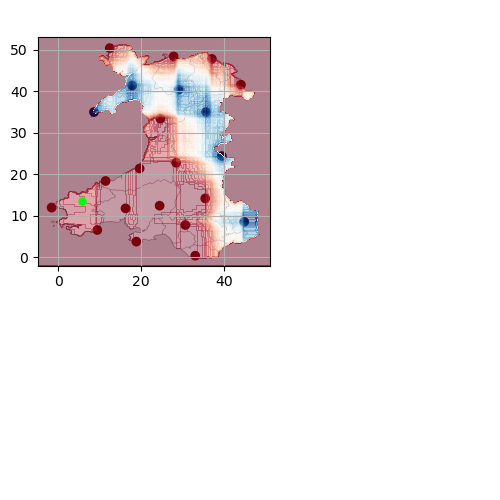

iteration  1
Accuracy is 0.6619627375023058
iteration  2
Accuracy is 0.6973805570927873
iteration  3
Accuracy is 0.7011621472053127
iteration  4
Accuracy is 0.6736456988255549
iteration  5
Accuracy is 0.663008055094386
iteration  6
Accuracy is 0.7361802865399988
iteration  7
Accuracy is 0.7153969132386399
iteration  8
Accuracy is 0.7143515956465597
iteration  9
Accuracy is 0.8147328291213183
iteration  10
Accuracy is 0.8130111295578921
iteration  11
Accuracy is 0.8111971960892824
iteration  12
Accuracy is 0.8197442046362909
iteration  13
Accuracy is 0.7924737133370227
iteration  14
Accuracy is 0.8496587345508209
iteration  15
Accuracy is 0.8552850027670171
iteration  16
Accuracy is 0.8618028653999877
iteration  17
Accuracy is 0.8385599212937342
iteration  18
Accuracy is 0.8469532066654368
iteration  19
Accuracy is 0.8686589190186312
iteration  20
Accuracy is 0.8404353440324663
iteration  21
Accuracy is 0.819252290475312
experiment:  17


<IPython.core.display.Javascript object>


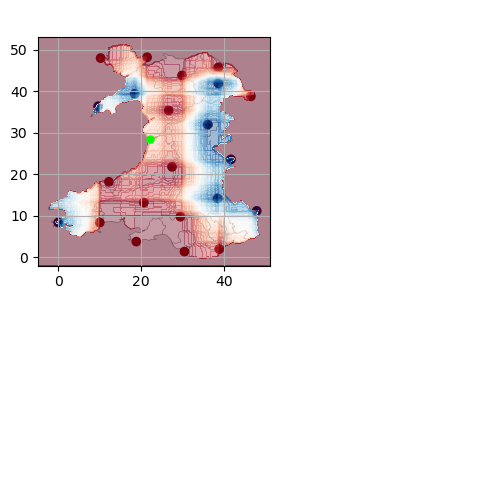

iteration  1
Accuracy is 0.402600996126176
iteration  2
Accuracy is 0.39509930517124764
iteration  3
Accuracy is 0.3870134661501568
iteration  4
Accuracy is 0.33855992129373425
iteration  5
Accuracy is 0.6919080120518969
iteration  6
Accuracy is 0.7294164668265388
iteration  7
Accuracy is 0.8020352948410502
iteration  8
Accuracy is 0.8291520629650126
iteration  9
Accuracy is 0.8530406444075509
iteration  10
Accuracy is 0.8363770522043903
iteration  11
Accuracy is 0.8839697472790998
iteration  12
Accuracy is 0.8611572280637029
iteration  13
Accuracy is 0.8519338375453483
iteration  14
Accuracy is 0.8489516079444137
iteration  15
Accuracy is 0.8610035048883969
iteration  16
Accuracy is 0.8388366230092849
iteration  17
Accuracy is 0.8341019492098629
iteration  18
Accuracy is 0.8345323741007195
iteration  19
Accuracy is 0.8548545778761606
iteration  20
Accuracy is 0.863555309598475
iteration  21
Accuracy is 0.8639857344893316
experiment:  18


<IPython.core.display.Javascript object>


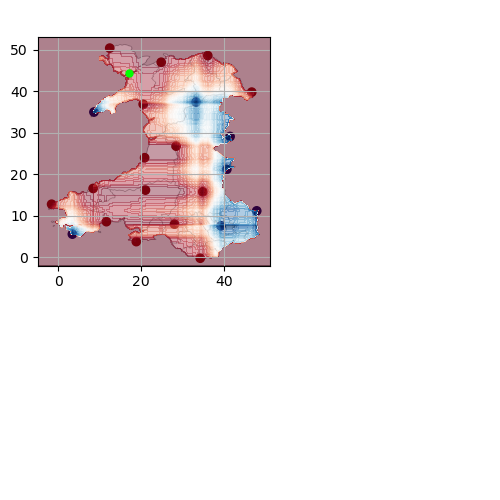

iteration  1
Accuracy is 0.5114677488778209
iteration  2
Accuracy is 0.416805017524442
iteration  3
Accuracy is 0.6739224005411055
iteration  4
Accuracy is 0.7967472176105269
iteration  5
Accuracy is 0.8218348398204514
iteration  6
Accuracy is 0.821619627375023
iteration  7
Accuracy is 0.8210354793088606
iteration  8
Accuracy is 0.7771936297116153
iteration  9
Accuracy is 0.7741499108405583
iteration  10
Accuracy is 0.7922892455266556
iteration  11
Accuracy is 0.8046793334563118
iteration  12
Accuracy is 0.8092295394453668
iteration  13
Accuracy is 0.7975158334870565
iteration  14
Accuracy is 0.862878927627129
iteration  15
Accuracy is 0.8471684191108652
iteration  16
Accuracy is 0.8622332902908443
iteration  17
Accuracy is 0.8671524319006333
iteration  18
Accuracy is 0.8541781959048146
iteration  19
Accuracy is 0.8555002152124455
iteration  20
Accuracy is 0.8582672323679518
iteration  21
Accuracy is 0.8651847752567177
experiment:  19


<IPython.core.display.Javascript object>


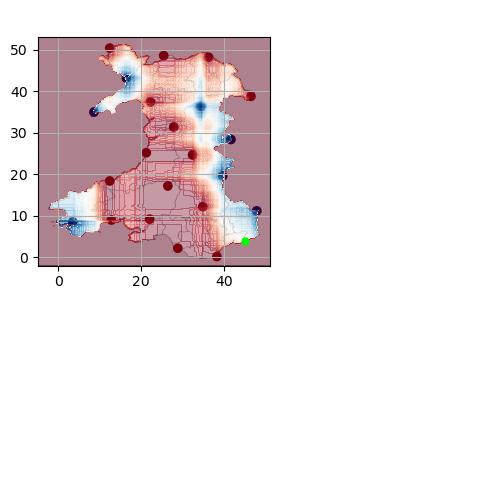

iteration  1
Accuracy is 0.5405214290106376
iteration  2
Accuracy is 0.642716595954006
iteration  3
Accuracy is 0.6736764434606162
iteration  4
Accuracy is 0.6861280206603948
iteration  5
Accuracy is 0.7254196642685852
iteration  6
Accuracy is 0.7273873209125008
iteration  7
Accuracy is 0.747555801512636
iteration  8
Accuracy is 0.7467256963659842
iteration  9
Accuracy is 0.7175490376929226
iteration  10
Accuracy is 0.7449117628973744
iteration  11
Accuracy is 0.739439217856484
iteration  12
Accuracy is 0.7529976019184652
iteration  13
Accuracy is 0.7641271598106131
iteration  14
Accuracy is 0.7692615138658304
iteration  15
Accuracy is 0.8197749492713522
iteration  16
Accuracy is 0.8295209985857468
iteration  17
Accuracy is 0.8200516509869028
iteration  18
Accuracy is 0.8246018569759577
iteration  19
Accuracy is 0.8638320113140256
iteration  20
Accuracy is 0.8754534833671525
iteration  21
Accuracy is 0.8459078890733567
experiment:  20


<IPython.core.display.Javascript object>


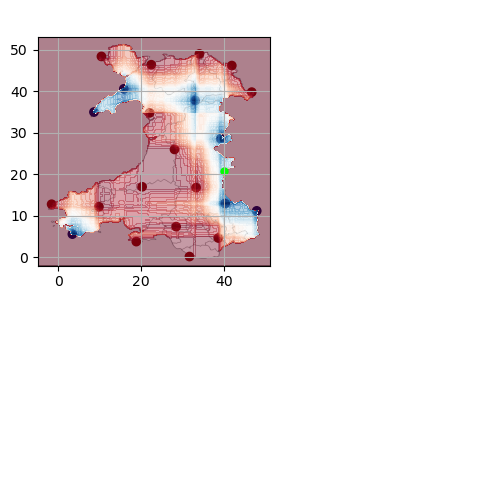

iteration  1
Accuracy is 0.6447149972329829
iteration  2
Accuracy is 0.5808583902109082
iteration  3
Accuracy is 0.7433745311443153
iteration  4
Accuracy is 0.75312058045871
iteration  5
Accuracy is 0.7556723851687881
iteration  6
Accuracy is 0.7398696427473406
iteration  7
Accuracy is 0.7510606899096107
iteration  8
Accuracy is 0.7583471684191109
iteration  9
Accuracy is 0.7484473959294103
iteration  10
Accuracy is 0.7555801512636044
iteration  11
Accuracy is 0.7559798315193998
iteration  12
Accuracy is 0.7531513250937711
iteration  13
Accuracy is 0.7838037262497695
iteration  14
Accuracy is 0.8086146467441432
iteration  15
Accuracy is 0.8313349320543565
iteration  16
Accuracy is 0.8270921724159134
iteration  17
Accuracy is 0.8381909856730001
iteration  18
Accuracy is 0.8509807538584517
iteration  19
Accuracy is 0.8506733075078399
iteration  20
Accuracy is 0.8536555371087745
iteration  21
Accuracy is 0.876222099243682


In [7]:
from random import randint
import time

valid_seeds = [27,12,15,21,25,36,37,41,45,48,50,51,52,53,54,57,61,63,64,71,75]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            hblauColor(landpoints[value],threshold_low1,threshold_high1,threshold_low2,threshold_high2)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], hblauColor(nextpoint,threshold_low1,threshold_high1,threshold_low2,threshold_high2)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 87.62 %
Improvement is = 23.15 %


In [9]:
Results

[[0.42495234581565516,
  0.7998524257517063,
  0.7983766832687696,
  0.7755641640533727,
  0.7679087499231384,
  0.7724897005472545,
  0.774088421570436,
  0.7927504150525734,
  0.8411117260038123,
  0.8633400971530468,
  0.8555002152124455,
  0.8777593309967411,
  0.8708417881079752,
  0.8614954190493759,
  0.8444936358605424,
  0.8525794748816331,
  0.8367767324601857,
  0.8333640779683945,
  0.8460001229785402,
  0.8261390887290168,
  0.8194982475558015],
 [0.6782573940847322,
  0.7116768123962368,
  0.6924921601180594,
  0.708325647174568,
  0.6854823833241099,
  0.6951054540982599,
  0.6926458832933653,
  0.7683699194490562,
  0.774426612556109,
  0.7872163807415606,
  0.8190063333948226,
  0.8726249769415237,
  0.8657074340527577,
  0.864908073541167,
  0.8800959232613909,
  0.8681362602225912,
  0.8663530713890426,
  0.863709032773781,
  0.8533788353932239,
  0.8406813011129558,
  0.8497817130910656],
 [0.4017094017094017,
  0.6497263727479555,
  0.5754473344401402,
  0.60514665

In [10]:
np.savetxt('hblauIsolated', Results)